South King County Opportunity Youth
===================
This notebbok estimates the population of opportunity youth in each region. 

<h1>Importing Libraries and Database  </h1>

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.data import data_collection

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
DBNAME = "opportunity_youth"

In [6]:
conn = psycopg2.connect(dbname=DBNAME)

<h1>Querying Data</h1>
We chose Puma's based on the school districs that were shown in the 2016 Report: Auburn, Federal Way, Highline, Kent, Renton, (South) Seattle, and Tukwila was what the origonal data included. We filtered by Age, Job status, and school status based on the definition of oppurtunity youth. 

In [7]:
# puma correlate to South King county regions
# esr = '3','6' is the unemployed
# fschp = '0', is not enrolled in school
oy_df = pd.read_sql('''SELECT * 
FROM pums_2017
WHERE puma IN ('11612','11613','11614','11615','11604', '11610', '11611')
AND agep BETWEEN '16' AND '24'
AND esr IN ('3','6','NaN')
AND SCH IN ('0','1','NAN')
;''', conn)
oy_df.to_csv('tables/oy_df.csv', index = False)

This data frame was to select all the Youth

In [8]:
ty_df = pd.read_sql('''SELECT *
FROM pums_2017
WHERE puma IN ('11612','11613','11614','11615','11604', '11610', '11611')
AND agep BETWEEN '16' AND '24'
;''', conn)
ty_df.to_csv('tables/ty_df.csv', index = False)

<h1>Estimating Population of Opportunity Youth</h1>
I created a list of the population by using the sample weighted multiplier. Then I grouped them by each Puma(region). From that I took the sum of all the regions to get the total.


In [9]:
#a list of the OY by each region and the total OY population for all 7 regions
population = oy_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
estimated_population = sum(population)
estimated_population

11530.0

In [10]:
#a list of the youth by each region and the total youth population for all 7 regions
ty_population = ty_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
ty_estimated_population = sum(ty_population)

<h1>Setting up data for graphing</h1>
I hardcoded the Names, latitude and longitude of the pumas as a value in the region dictionary. The reason I did this was because I knew these weren't going to change during our project. 
Another option would have been to find the dataframe table that had a list of puma names and join them so you wouldnt have to hardcode it. 

In [11]:
# dictionary of Puma number, and then sorting it by the OY population of each puma
# Used to organize the names of the puma which wasnt included in the dataframe
import operator
region_dic = {'11612': [population['11612'],'Federal Way,Des moines Cities & Vashon island', 47.3223, -122.3126, 110, ty_population['11612']],
 '11613': [population['11613'],'Kent City',47.3809, -122.2348, 34.43, ty_population['11613']],
 '11611': [population['11611'],'Burien, SeaTac, Tukwita Cities',47.4668, -122.3405, 31, ty_population['11611']],
 '11614': [population['11614'],'Auburn City & Lakeland', 47.3073, -122.2285, 35, ty_population['11614']],
 '11604': [population['11604'],'South East Seattle', 47.5923, -122.3022, 30.5, ty_population['11604']],
 '11615': [population['11615'],'Maple Valley, Covingtion and Enumclaw Cities', 47.3903, -122.0454, 18, ty_population['11615']],
 '11610': [population['11610'],'Renton City, Fairwood, Bryn Mawr and Skyway', 47.4797, -122.2079, 31, ty_population['11610']]}

sort_region_dic = dict(sorted(region_dic.items(), key=operator.itemgetter(1), reverse = True))

I created two lists from the sorted region dictionary that are used as the x and y axis on the graph.

In [12]:
city_list = [item[1] for item in sort_region_dic.values()] 
estimated_population_region = [item[0] for item in sort_region_dic.values()] 

In [13]:
# adjusted city list so the string is on muliple lines in the graph
city_list_adj = [sub.replace(',',',\n').replace(' &',',\n').replace(' and',',\n') for sub in city_list]

<h1>Plotting A Bar Chart</h1>
Created a bar graph comparing the Estimated Population per region 

No handles with labels found to put in legend.


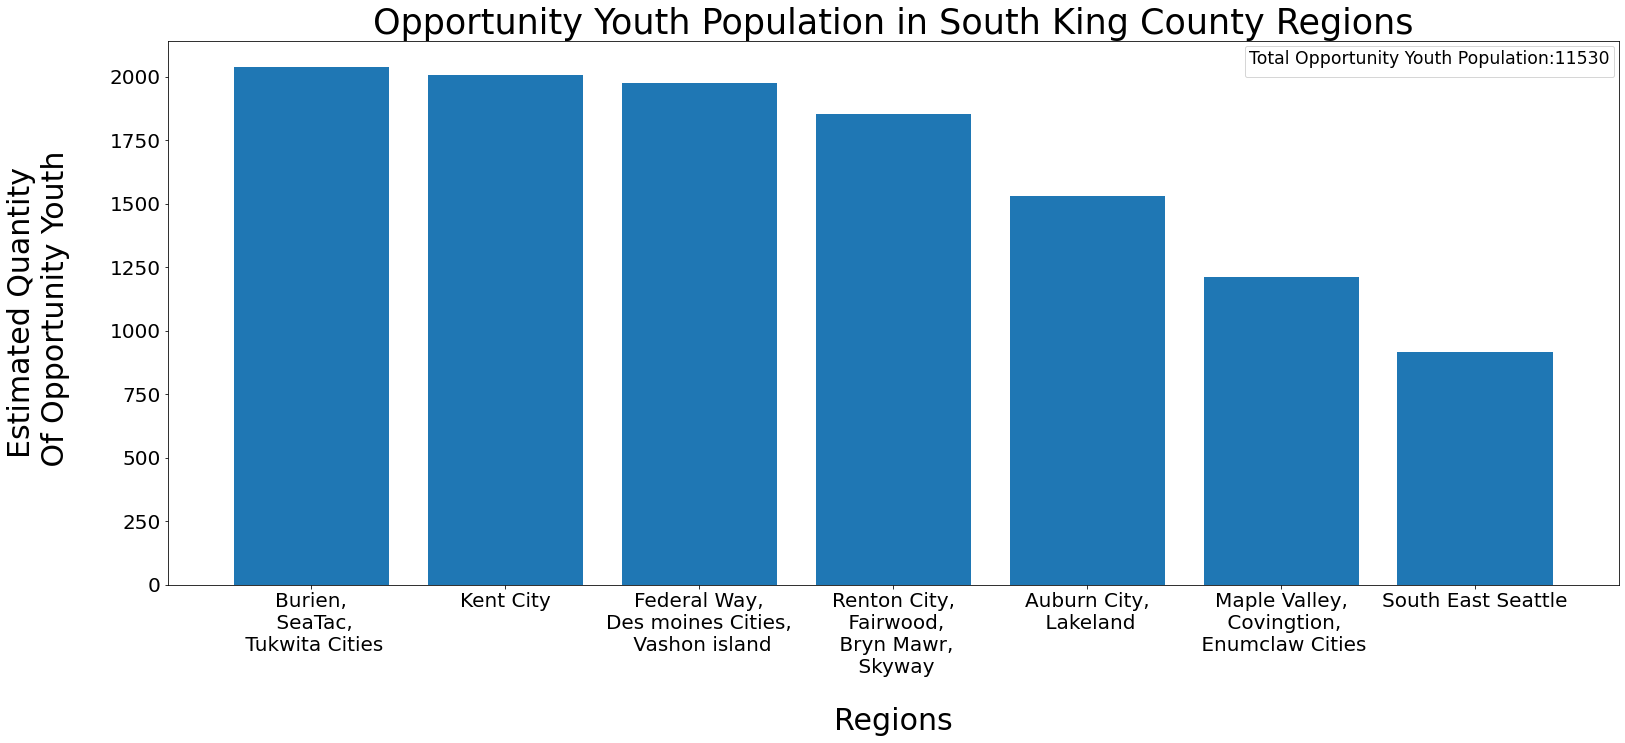

In [14]:
city_list = [item[1] for item in sort_region_dic.values()]  # created a list of the cities based on the region_dic 
estimated_population_region = [item[0] for item in sort_region_dic.values()] # created a listed of the estimated population per region
# adjusted city list so the string is on muliple lines in the graph
city_list_adj = [sub.replace(',',',\n').replace(' &',',\n').replace(' and',',\n') for sub in city_list]

#Printing a Bar graph of the population estimate per each puma(region)
figure, ax = plt.subplots(1, 1, figsize = (26,10));

x = city_list_adj;
y = estimated_population_region;
ax.bar(x, y);


ax.set_ylabel('Estimated Quantity\n Of Opportunity Youth', fontsize = 30, rotation = 90, labelpad = 40);
ax.set_xlabel('Regions', fontsize = 30, labelpad = 30);
ax.set_title('Opportunity Youth Population in South King County Regions', fontsize = 35);
ax.set_xticklabels(city_list_adj, wrap = True);
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(title =f'Total Opportunity Youth Population:{int(estimated_population)}' , title_fontsize= 'xx-large', fancybox=True);             

In [15]:
figure.savefig('OYPopulationByRegion.png',dpi=300, bbox_inches='tight') 

In [16]:
import folium
import pandas as pd
import branca as cm
from folium.plugins import FloatImage

In [17]:
#setting up variables form the dictionary to be used for the map below
name = [i[1] for i in region_dic.values()]
population_values = [i[0] for i in region_dic.values()]
lat = [i[2] for i in region_dic.values()]
lon = [i[3] for i in region_dic.values()]

<h1>Plotting the Map</h1>
I used Folium and the information from the 2017 pums data to create a map visualization by correlating circle size to OY population. This could be used to look at any geographical trends.

In [18]:
m = folium.Map(location=[47.45,-122.3321], zoom_start=11)

#loop through each oy,lat,long and population. 
for i in range(0,len(region_dic.values())):
   folium.CircleMarker(
      location=[lat[i], lon[i]],
      popup= name[i] + ', \n OY Population %:' + str((population_values[i]/ty_population[i])*100),
      radius= 500 *(population_values[i]/ty_population[i]),
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)

#creates a legend in the upper left portion. 
colormap = cm.colormap.LinearColormap(colors=['blue','blue','blue','blue','blue'], index=[0,10,20,30,40],vmin=0,vmax=40);
colormap.caption = '% Of Opportunity Youth per Total Youth';
colormap.add_to(m);
m

In [39]:
m.save('opportunity_youth_map.html')